# Ariana Grande Markov Chains
A notebook using Ariana Grande's song lyrics to build a Markov chain lyric generator
### By: David Taylor

### Using lyricsgenius library to download all of Mac Miller's song lyrics

In [1]:
import lyricsgenius as genius
ARTIST = 'Ariana Grande'

# access lyricsgenius api with client access token
with open('/Users/david/Documents/blog_source_creds/client_access_token.txt') as f:
    api = genius.Genius(f.read().strip('\n'))
artist = api.search_artist(ARTIST)
lyrics = artist.save_lyrics()

Searching for songs by Ariana Grande...

Song 1: "7 rings"
Song 2: "ABC"
Song 3: "Ain't About What You Got"
Song 4: "All I Need"
Song 5: "All I Want for Christmas Is You"
Song 6: "Almost Is Never Enough"
Song 7: "Almost Is Never Enough (Soundtrack Version)"
Song 8: "Ariana Grande"
Song 9: "Ariana Grande's Tattoos"
Song 10: "Baby I"
Song 11: "Baby I (a-Director's Cut Radio Edit)"
Song 12: "Baby I (Cosmic Dawn Radio Edit)"
Song 13: "Baby Loves (Intro)"
Song 14: "Bad Decisions"
Song 15: "Bad Decisions [DWT Version]"
Song 16: "​bad idea"
Song 17: "Bang Bang (3LAU Remix)"
Song 18: "Bang Bang (Dada Life Remix)"
Song 19: "Be Alright"
Song 20: "Be Alright (Demo)"
Song 21: "Be Alright (Justin Bieber Cover)"
Song 22: "Beauty and the Beast"
Song 23: "Be My Baby"
Song 24: "Best Mistake"
Song 25: "Better Days - Live from One Love Manchester"
Song 26: "Better Left Unsaid"
Song 27: "​better off"
"Better Off (Instrumental)" does not contain lyrics. Rejecting.
Song 28: "Blame (Am I)"
Song 29: "​blazed"

SKIPPING "​bloodline" (already found in artist collection)
SKIPPING "Break Free (Zedd’s Extended Mix)" (already found in artist collection)
SKIPPING "Breathin (SG Lewis Remix)" (already found in artist collection)
SKIPPING "Dangerous Woman [Deluxe Booklet]" (already found in artist collection)
SKIPPING "Everyday [DWT Version]" (already found in artist collection)
SKIPPING "​fake smile" (already found in artist collection)
SKIPPING "​ghostin" (already found in artist collection)
SKIPPING "Girls (Demo)" (already found in artist collection)
SKIPPING "Goodnight n go (live at the BBC)" (already found in artist collection)
SKIPPING "Gratefulness" (already found in artist collection)
SKIPPING "Growth" (already found in artist collection)
SKIPPING "​in my head" (already found in artist collection)
SKIPPING "Into You (3LAU Remix)" (already found in artist collection)
SKIPPING "Into You (Grey Remix)" (already found in artist collection)
SKIPPING "Intro [Moonlight]" (already found in artist colle

In [2]:
import pandas as pd

# reformat lyrics into pandas df
songs = lyrics.get('songs')
lyric_list = [(song.get('title'), song.get('album'),
               song.get('lyrics')) for song in songs]
df = pd.DataFrame(lyric_list, columns=['title', 'album', 'lyrics'])

# writing lyric df to csv for reuse
file_path = '/Users/david/blog-source/mac_markov/lyrics_ariana.csv'
df.to_csv(file_path, index=False)

In [5]:
# read data back in to pandas df (useful for continuing work because API retrieval takes a while)
df = pd.read_csv('lyrics_ariana.csv')
df.dropna()
df.head()

,title,album,lyrics
0,7 rings,"thank u, next","Snippet\n[Verse]\nLashes and diamonds, ATM mac..."
1,ABC,NaN,[Intro]\nA-buh-buh-buh-buh-buh (a-buh-buh-buh-...
2,Ain't About What You Got,NaN,[Verse 1]\nYeah!\nI heard a couple of bad thin...
3,All I Need,NaN,\n Lyrics for this song h...
4,All I Want for Christmas Is You,NaN,I don't want a lot for Christmas\nThere is jus...


### cleaning up lyric data

In [6]:
import re
from profanity import profanity
remove = '-/()[]'


def clean_lyrics(song):
    # remove parenthetical comments
    lyrics1 = re.sub('[\(\[].*?[\)\]]', '', song)

    # remove punctuation and numerics, then separate lines into list
    lyrics2 = ''.join(
        ch for ch in lyrics1 if ch not in remove).splitlines()

    # remove one-word and blank lyric lines
    lyrics3 = [line for line in list(
        filter(None, lyrics2)) if len(line.split()) > 1]

    # join lines with periods and set lowercase
    lyrics4 = ' '.join(lyrics3).lower()  # separate li

    # censor lyrics
    return profanity.censor(lyrics4)


df['lyrics'].dropna(inplace=True)
df['lyrics'] = df['lyrics'].apply(clean_lyrics)
df['lyrics'].dropna(inplace=True)
df.head()

# combine all lyrics into one string
lyric_text = ''.join(df['lyrics']).lower()

### lyrics metadata

In [7]:
print(str(len(df)) + ' songs')
print(str(len(lyric_text.split())) + ' words')

166 songs
49676 words


### marking wordcloud with combined lyrics

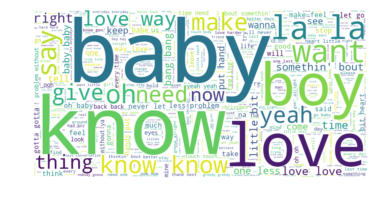

In [9]:
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from wordcloud import WordCloud, STOPWORDS

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# words to exclude from cloud -- don't add any meaning
stopwords = set(STOPWORDS)
stop_adds = ['got', 'aint', 'im', 'cause', 'don\'t', 'ain\'t']
for word in stop_adds:
    stopwords.add(word)

# create high-res wordcloud with 500 most common words in dataset
wc = WordCloud(background_color="white", max_words=500,
               stopwords=stopwords, width=800, height=400)
wc.generate(lyric_text)
wc.to_file(path.join(d, 'ariana_wordcloud.png'))

# plot cloud
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize=(20, 10))
plt.show()

### Markov chain builder

In [10]:
# set default values for custom song generation (can be altered at function calls)
LINE_LENGTH = 8
STANZA_LENGTH = 4
STANZA_COUNT = 6

In [11]:
import random


def generate_line(lyric_text, line_length=LINE_LENGTH):
    words = lyric_text.split()  # separate lyrics into list of words
    index = 2  # initialize index count for markov chain of order 2
    chain = {}  # initialize dictionary of lyrics
    gen_length = line_length  # word count of output

    for word in words[index:len(words)-1]:
        key = str(words[index - 2] + ' ' + words[index - 1])
        if key in chain:  # check if word is already in dictionary
            chain[key].append(str(word + ' ' + words[index + 1]))
        else:
            chain[key] = [str(word + ' ' + words[index + 1])]
        index += 1

    words1 = random.choice(list(chain.keys()))
    new_lyric = words1.capitalize()

    while len(new_lyric.split(' ')) < gen_length:
        words2 = random.choice(chain[words1])
        words1 = words2
        new_lyric += ' ' + words2

    return new_lyric

In [12]:
def generate_song(lyrics, line_length=LINE_LENGTH, stanza_length=STANZA_LENGTH, stanzas=STANZA_COUNT):
    song = ''
    for stanza in range(stanzas):  # generate desired number of stanzas per song
        paragraph_split = generate_line(lyrics, line_length=(
            line_length * stanza_length)).split(' ')  # generate list of words for a stanza
        i = line_length
        while i <= len(paragraph_split):  # insert newlines after each line in the stanza
            paragraph_split.insert(i, '\n')
            i += line_length + 1
        # append each stanza onto the song
        song += ' '.join(paragraph_split) + '\n'
    return song

In [15]:
def write_song(lyric_text, to_txt=True):
    new_song = generate_song(lyric_text)
    if to_txt:
        with open('new_song_ariana.txt', 'w') as f:
            f.write(new_song)
    print(new_song)

In [16]:
write_song(lyric_text, True)

Of having him just put your lips on 
 mine and honey it ain’t a player, i 
 just... you give me that kinda somethin' want 
 it all the time, need it every day 

Sure the one i love passionate but i 
 wanted to hug you plus you don't know 
 they don't know they don't know they don't 
 know about... mmmm, listen, watch me they don't 

Just unsee sips tea, and it's been kinda 
 tough cause he's only in town and we're 
 gonna do some winter things, heywish you knew 
 better boy, if you want it, take it 

Me don't be gone too long 'cause you 
 give me something to make him stay wrapped 
 in his arms by the fireplace will be 
 it will be i figured no one would 

The presents underneath the christmas tree i just 
 want you to remember how it is, how 
 it could be you tell me if he 
 won't be christmas i just want to break 

But i'll take a bullet straight through my 
 brain yes i would die for you baby 
 so one last time i need to be 
 into you got everyone watchin' us, so, baby, 


